In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import shutil

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/DLS-1/Project"

SRC_CROPPED_DIR       = os.path.join(BASE_DIR, "Cropped")
CROPPED_DIR           = "/content/Cropped"

TRAIN_CSV             = os.path.join(BASE_DIR, "train_celeba.csv")
VAL_CSV               = os.path.join(BASE_DIR, "val_celeba.csv")
CROPPED_LANDMARKS_CSV = os.path.join(BASE_DIR, "cropped_landmarks_celeba.csv")

MODEL_PARAMS_PT       = os.path.join(BASE_DIR, "model_params_stackedhourglass.pt")

## Шаг 1. Копируем изображения в локальную папку из Google Drive

Это необходимо, т.к. доступ к Google Drive недостаточно быстрый. Это приводит к тому, что обучение неприемлемо замедляется.

In [5]:
os.makedirs(CROPPED_DIR, exist_ok=True)

shutil.copytree(SRC_CROPPED_DIR, CROPPED_DIR, dirs_exist_ok=True)

'/content/Cropped'

## Шаг 2. Определяем датасет CelebAHeatmapDataset

Датасет будет источником пар данных: изображение (256x256) + heatmap (64x64).

Heatmap генерируется "на лету" при выдаче очередного изображения.

In [6]:
HEATMAP_SIZE = 64
INPUT_SIZE = 256
SIGMA = 2   # в пикселях heatmap'ы

def landmarks_to_heatmaps(landmarks,
                          heatmap_size=HEATMAP_SIZE,
                          input_size=INPUT_SIZE,
                          sigma=SIGMA):
    """
    landmarks: (5, 2) в координатах input_size x input_size
    return: heatmaps (5, heatmap_size, heatmap_size) в координатах heatmap_size x heatmap_size
    """
    # выделяем пямять под все heatmap-ы (в данном случае точек 5)
    heatmaps = np.zeros((landmarks.shape[0], heatmap_size, heatmap_size), dtype=np.float32)

    # вычисляем масштабный коэффициент пересчета координат: image coords -> heatmap coords
    scale = heatmap_size / input_size

    # создаём meshgrid для одной heatmap-ы
    xx, yy = np.meshgrid(np.arange(heatmap_size), np.arange(heatmap_size))

    # вычисляем в цикле heatmap для каждой точки в landmarks
    for i, (x, y) in enumerate(landmarks):

        x_hm = x * scale # scale from image coords -> heatmap coords
        y_hm = y * scale # scale from image coords -> heatmap coords

        # Обрезаем координаты, чтобы не выйти за пределы размеров heatmap-ы
        x_hm = min(max(0, int(x_hm)), heatmap_size - 1)
        y_hm = min(max(0, int(y_hm)), heatmap_size - 1)

        heatmaps[i] = np.exp(-((xx - x_hm) ** 2 + (yy - y_hm) ** 2) / (2 * sigma ** 2))

    return heatmaps


In [7]:
class CelebAHeatmapDataset(Dataset):
    def __init__(self, img_dir, df,
                 input_size=INPUT_SIZE, heatmap_size=HEATMAP_SIZE, sigma=SIGMA):

        self.img_dir = img_dir
        self.lm_df = df

        self.input_size = input_size
        self.heatmap_size = heatmap_size
        self.sigma = sigma

    def __len__(self):
        return len(self.lm_df)

    def __getitem__(self, idx):
        row = self.lm_df.iloc[idx]
        img_name = row["image_id"]

        # image
        img_path = os.path.join(self.img_dir, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        img = img.astype(np.float32) / 255.0  # [0,1]

        # landmarks
        landmarks = np.array([
            [row["lefteye_x"], row["lefteye_y"]],
            [row["righteye_x"], row["righteye_y"]],
            [row["nose_x"], row["nose_y"]],
            [row["leftmouth_x"], row["leftmouth_y"]],
            [row["rightmouth_x"], row["rightmouth_y"]],
        ], dtype=np.float32)

        # heatmaps
        heatmaps = landmarks_to_heatmaps(
            landmarks,
            heatmap_size=self.heatmap_size,
            input_size=self.input_size,
            sigma=self.sigma
        )

        # to tensor
        img = torch.from_numpy(img).permute(2, 0, 1)
        heatmaps = torch.from_numpy(heatmaps)

        return img, heatmaps


## Шаг 3. Создаем датасеты и даталоадеры для train и val наборов.

Отобранные ранее 10 000 изображений мы уже разбили на две части в соотношении 80/20. В 10 000 изображений находятся ровно по 20 фото для 500 персон (точно 16 в train и 4 в val).

Создаем два датасета, затем два даталоадера. Выполняем визуальный контроль работы даталоадера train_loader.

In [8]:
train_df  = pd.read_csv(TRAIN_CSV)
val_df    = pd.read_csv(VAL_CSV)
lm_df     = pd.read_csv(CROPPED_LANDMARKS_CSV)

train_df = lm_df.merge(
    train_df[["image_id", "person_id"]],
    on="image_id",
    how="inner"
)
print("Train samples:", len(train_df))

val_df = lm_df.merge(
    val_df[["image_id", "person_id"]],
    on="image_id",
    how="inner"
)
print("Val samples:", len(val_df))

train_dataset = CelebAHeatmapDataset(
    img_dir=CROPPED_DIR,
    df=train_df
)

val_dataset = CelebAHeatmapDataset(
    img_dir=CROPPED_DIR,
    df=val_df
)

Train samples: 8000
Val samples: 2000


In [9]:
BATCH_SIZE = 16
NUM_WORKERS = 2

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=(device=="cuda")
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=(device=="cuda")
)


In [10]:
imgs, heatmaps = next(iter(train_loader))

print("Images:", imgs.shape)       # (B, 3, 256, 256)
print("Heatmaps:", heatmaps.shape) # (B, 5, 64, 64)

Images: torch.Size([16, 3, 256, 256])
Heatmaps: torch.Size([16, 5, 64, 64])


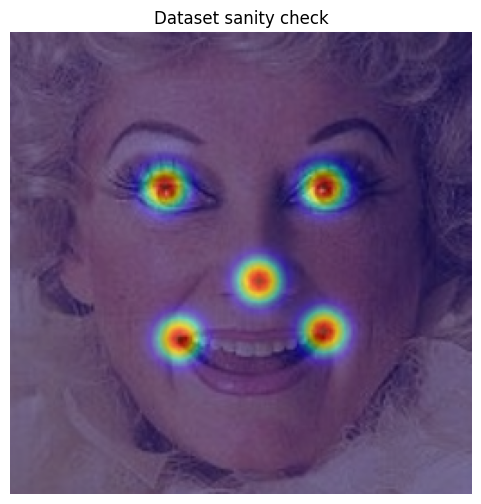

In [11]:
img_np = imgs[0].permute(1, 2, 0).numpy()
hm_sum = heatmaps[0].sum(0)
hm_sum_up = cv2.resize(
    hm_sum.numpy(),
    (INPUT_SIZE, INPUT_SIZE),
    interpolation=cv2.INTER_LINEAR
)

plt.figure(figsize=(6, 6))
plt.imshow(img_np)
plt.imshow(hm_sum_up, alpha=0.5, cmap="jet")
plt.axis("off")
plt.title("Dataset sanity check")
plt.show()

## Шаг 4. Определяем классы ResidualBlock, Hourglass, StackedHourglass.

**ResidualBlock**. Состоит из двух сверточных слоев с последующим BatchNorm. В обход них проходит скип-коннекшн (может изменять количество каналов, если вход и выход отличаются). Разрешение изображения на входе м.б. любым, и оно не изменяется при прохождении блока.

**Hourglass**. Определяется рекурсивно. Количество рекурсивных вложений передается в параметре конструктора depth. Перед каждым рекурсивным вложением понижает разрешение в 2 раза. После рекурсивного вызова исходное разрешение восстанавливается. При depth=4 это дает: 256->128->64->32->64->128->256. Skip-connection идет в своём входном разрешении внутри каждого рекурсивного блока. Количество каналов не изменяется.

**StackedHourglass**. Обычно это два последовательно соединенные Hourglass объекта. Hourglass не изменяет разрешение изображения. Выход первого подается на вход второго.

У каждого Hourglass блока есть набор из голов (в нашем случае 5 голов, по одной на каждую ключевую точку лица). Каждая голова возвращает heatmap 64x64. Головы второго Hourglass уточняют показания голов первого Hourglass.

При обучении мы минимизируем суммарную ошибку обоих наборов голов. При инференсе используются только показания последнего (второго) набора голов.

In [12]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        # output = (input + 2 * padding - kernel_size) // stride + 1
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        if in_channels != out_channels:
            self.skip = nn.Conv2d(in_channels, out_channels, 1, bias=False)
        else:
            self.skip = nn.Identity()

    def forward(self, x):
        residual = self.skip(x)

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        out += residual
        out = F.relu(out)

        return out

In [13]:
class Hourglass(nn.Module):
    def __init__(self, depth, channels):
        super().__init__()
        self.depth = depth
        self.channels = channels

        self.up1 = ResidualBlock(channels, channels)
        self.pool = nn.MaxPool2d(2, 2)
        self.low1 = ResidualBlock(channels, channels)

        if depth > 1:
            self.low2 = Hourglass(depth - 1, channels)
        else:
            self.low2 = ResidualBlock(channels, channels)

        self.low3 = ResidualBlock(channels, channels)
        self.up2 = nn.Upsample(scale_factor=2, mode="nearest")

    def forward(self, x):
        up = self.up1(x)

        low = self.pool(x)
        low = self.low1(low)
        low = self.low2(low)
        low = self.low3(low)
        low = self.up2(low)

        return up + low

In [14]:
class StackedHourglass(nn.Module):
    def __init__(self,
                 num_stacks=2,
                 num_landmarks=5,
                 channels=256,
                 depth=4):
        super().__init__()

        self.num_stacks = num_stacks

        # --- stem ---
        self.pre = nn.Sequential(
            # output = (input + 2 * padding - kernel_size) // stride + 1
            nn.Conv2d(3, 64, 7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            ResidualBlock(64, 128),
            nn.MaxPool2d(2, 2),

            ResidualBlock(128, 128),
            ResidualBlock(128, channels),
        )

        # --- stacks ---
        self.hgs = nn.ModuleList([
            Hourglass(depth, channels)
            for _ in range(num_stacks)
        ])

        self.features = nn.ModuleList([
            nn.Sequential(
                ResidualBlock(channels, channels),
                nn.Conv2d(channels, channels, 1),
                nn.BatchNorm2d(channels),
                nn.ReLU(inplace=True)
            )
            for _ in range(num_stacks)
        ])

        self.heads = nn.ModuleList([
            nn.Conv2d(channels, num_landmarks, 1)
            for _ in range(num_stacks)
        ])

        self.merge_features = nn.ModuleList([
            nn.Conv2d(channels, channels, 1)
            for _ in range(num_stacks - 1)
        ])

        self.merge_preds = nn.ModuleList([
            nn.Conv2d(num_landmarks, channels, 1)
            for _ in range(num_stacks - 1)
        ])

    def forward(self, x):
        x = self.pre(x)

        outputs = []

        for i in range(self.num_stacks):
            hg = self.hgs[i](x)
            feat = self.features[i](hg)
            pred = self.heads[i](feat)

            outputs.append(pred)

            if i < self.num_stacks - 1:
                x = x + self.merge_features[i](feat) + self.merge_preds[i](pred)

        return outputs

## Шаг 5. Обучаем модель.

Определяем функцию stacked_heatmap_loss(), как среднюю ошибку MSE по всем (в нашем случае по двум) наборам голов.

Обучаем сеть на 10 эпохах. Визуализируем прогресс в обучении, а именно сравниваем две heatmap-ы: цель (GT) и выход с последнего набора голов сети.

In [15]:
criterion = nn.MSELoss()

def stacked_heatmap_loss(preds, target):
    """
    preds: list of tensors [(B, K, H, W), ...]
    target: (B, K, H, W)
    """
    loss = 0.0
    for p in preds:
        loss += criterion(p, target)
    return loss / len(preds)


In [16]:
def train_one_epoch(model, loader, optimizer):
    model.train()
    total_loss = 0.0

    for imgs, heatmaps in tqdm(loader):
        imgs, heatmaps = imgs.to(device), heatmaps.to(device)

        preds = model(imgs)
        loss = stacked_heatmap_loss(preds, heatmaps)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

In [17]:
@torch.no_grad()
def validate(model, loader):
    model.eval()
    total_loss = 0.0

    for imgs, heatmaps in tqdm(loader):
        imgs, heatmaps = imgs.to(device), heatmaps.to(device)

        preds = model(imgs)
        loss = stacked_heatmap_loss(preds, heatmaps)

        total_loss += loss.item()

    return total_loss / len(loader)

In [18]:
def visualize_pred_vs_gt(model, loader):
    model.eval()

    imgs, gt = next(iter(loader))
    imgs = imgs.to(device)

    with torch.no_grad():
        preds = model(imgs)

    pred_hm = preds[-1][0].cpu()
    gt_hm = gt[0]

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.imshow(gt_hm.sum(0))
    plt.title("GT heatmap")

    plt.subplot(1,2,2)
    plt.imshow(pred_hm.sum(0))
    plt.title("Pred heatmap")

    plt.show()

100%|██████████| 125/125 [00:23<00:00,  5.43it/s]


Epoch [1/10] | Train Loss: 0.00415 | Val Loss: 0.00080


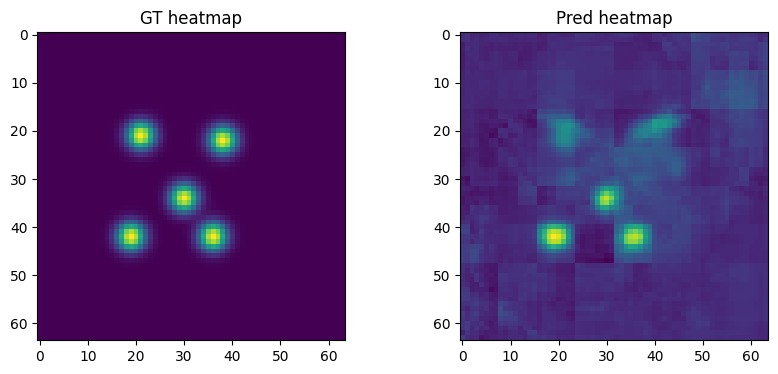

100%|██████████| 125/125 [00:23<00:00,  5.40it/s]


Epoch [2/10] | Train Loss: 0.00044 | Val Loss: 0.00032


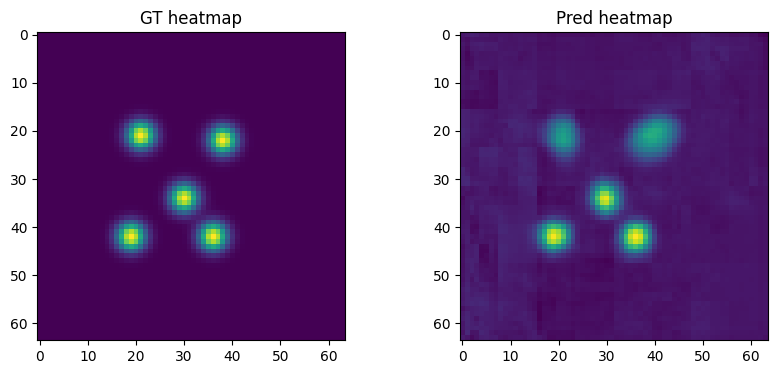

100%|██████████| 125/125 [00:23<00:00,  5.39it/s]


Epoch [3/10] | Train Loss: 0.00025 | Val Loss: 0.00026


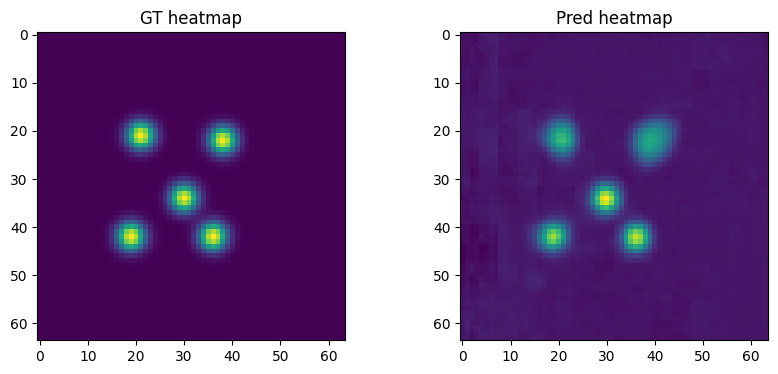

100%|██████████| 125/125 [00:23<00:00,  5.43it/s]


Epoch [4/10] | Train Loss: 0.00021 | Val Loss: 0.00023


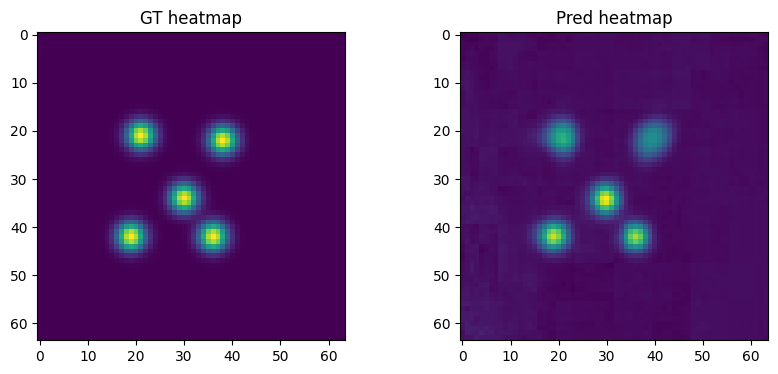

100%|██████████| 125/125 [00:23<00:00,  5.41it/s]


Epoch [5/10] | Train Loss: 0.00018 | Val Loss: 0.00022


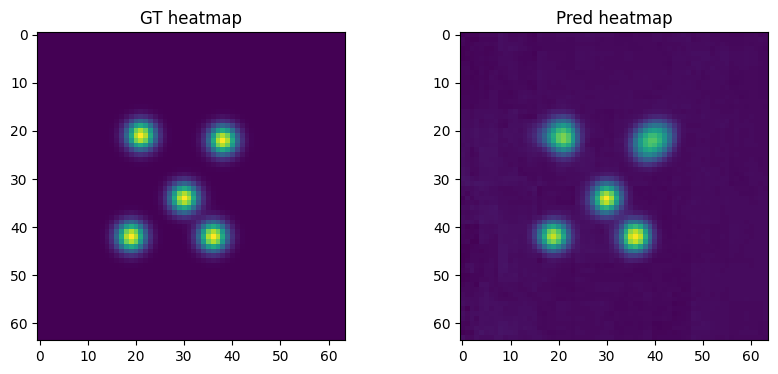

100%|██████████| 125/125 [00:23<00:00,  5.40it/s]


Epoch [6/10] | Train Loss: 0.00016 | Val Loss: 0.00020


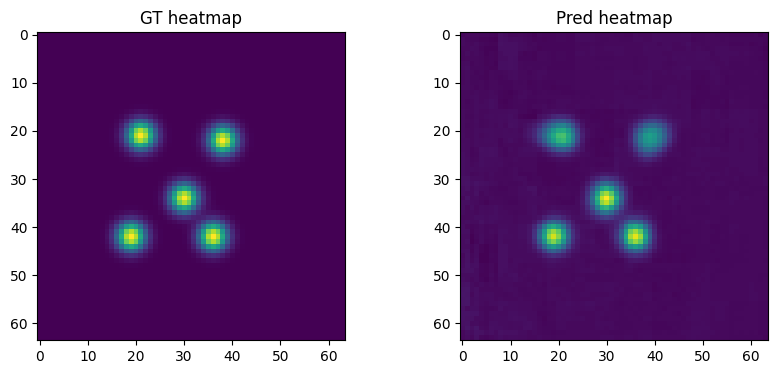

100%|██████████| 125/125 [00:23<00:00,  5.40it/s]


Epoch [7/10] | Train Loss: 0.00015 | Val Loss: 0.00018


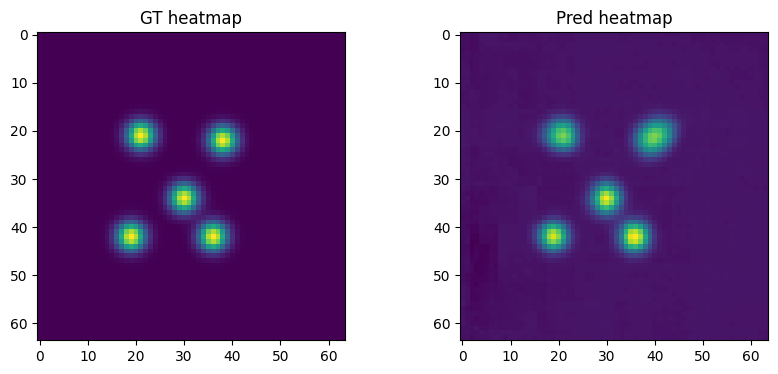

100%|██████████| 125/125 [00:23<00:00,  5.32it/s]


Epoch [8/10] | Train Loss: 0.00014 | Val Loss: 0.00018


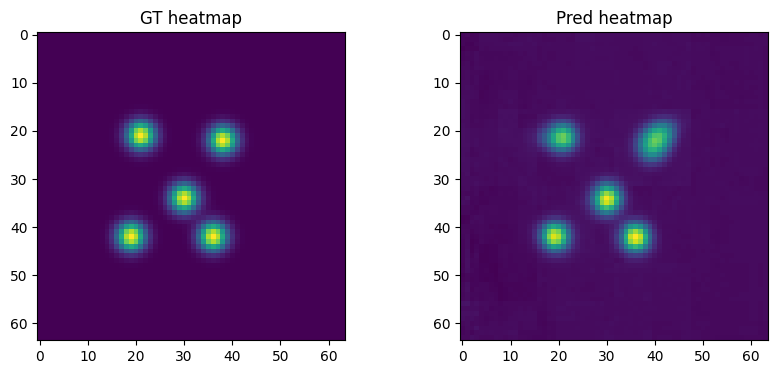

100%|██████████| 125/125 [00:23<00:00,  5.32it/s]


Epoch [9/10] | Train Loss: 0.00013 | Val Loss: 0.00017


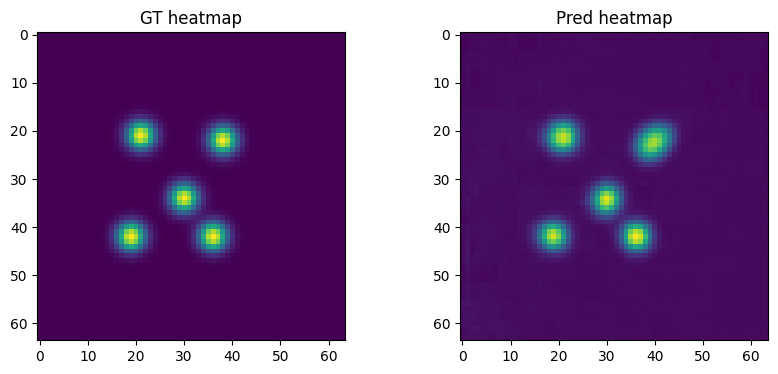

100%|██████████| 125/125 [00:23<00:00,  5.38it/s]


Epoch [10/10] | Train Loss: 0.00013 | Val Loss: 0.00016


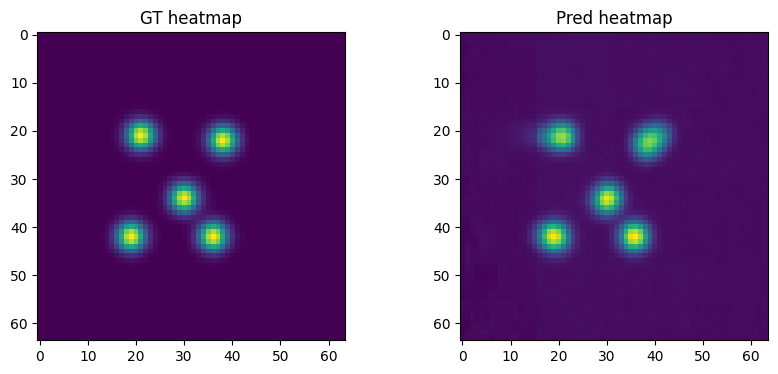

In [19]:
model = StackedHourglass(num_stacks=2, num_landmarks=5).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

NUM_EPOCHS = 10

for epoch in range(NUM_EPOCHS):
    train_loss = train_one_epoch(model, train_loader, optimizer)
    val_loss = validate(model, val_loader)

    print(
        f"\nEpoch [{epoch+1}/{NUM_EPOCHS}] | "
        f"Train Loss: {train_loss:.5f} | "
        f"Val Loss: {val_loss:.5f}"
    )

    visualize_pred_vs_gt(model, val_loader)

In [20]:
torch.save(model.state_dict(), MODEL_PARAMS_PT)